Let's define a couple of functions to show CSD molecules. We will query the CSD for a few octahedral iron complexes. We can use the `time` module to track how long a query takes.

Time taken: 0.21289396286


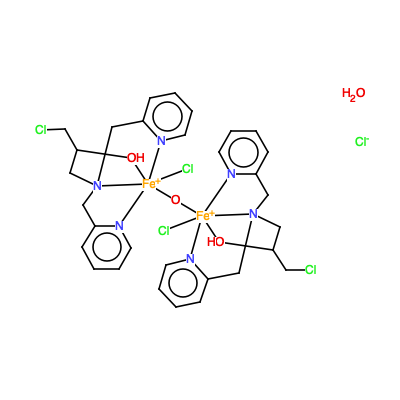

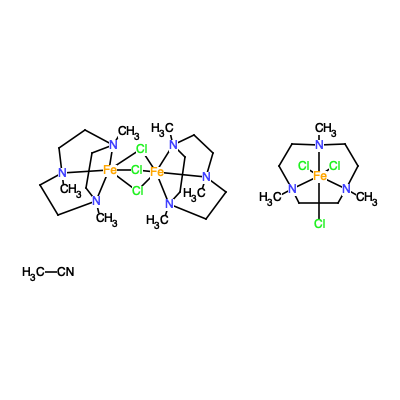

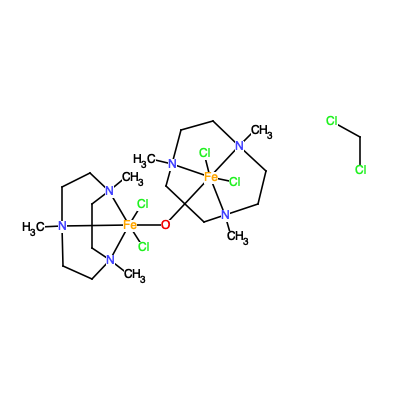

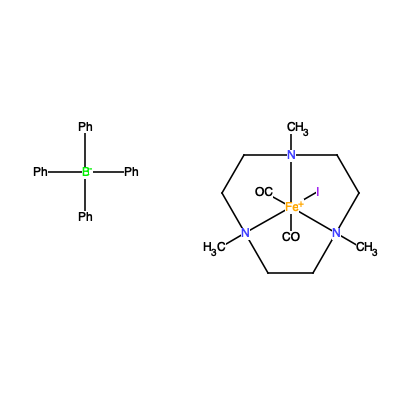

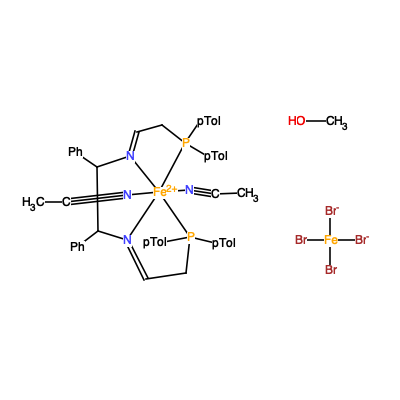

In [3]:
import ccdc.search as csearch
import ccdc.diagram as cdiagram
import numpy as np
import PIL
import random
import time

def stitch_images(imlist):
    for i in [5,4,3,2,1]:
        if (len(imlist) % i) == 0:
            break
    my_hstacks = []
    for j in range(i):
        my_hstacks += [np.vstack(imlist[len(imlist)/i*j:len(imlist)/i*(j+1)])]
    my_final = np.hstack(my_hstacks)
    return PIL.Image.fromarray(my_final)

def show_sample(results, sample_indices, display_type = 'sequential'):
    diagram_generator = cdiagram.DiagramGenerator()
    diagram_generator.settings.font_size = 12
    diagram_generator.settings.line_width = 1.6
    diagram_generator.settings.image_width = 400
    diagram_generator.settings.image_height = 400
    if display_type == 'tiled':
        my_things = [diagram_generator.image(results[i].molecule) for i in sample_indices]
        display(stitch_images(my_things))
    else:
        for i in sample_indices:
            display(diagram_generator.image(results[i].molecule))

substructure = csearch.QuerySubstructure()
fe_center = csearch.QueryAtom('Fe')
fe_center.num_bonds = 6
substructure.add_atom(fe_center)

query = csearch.SubstructureSearch()
query.add_substructure(substructure)
query.settings.must_have_elements = ['Fe']
query.settings.has_3d_coordinates = True
query.settings.only_organometallic = True
q = time.time()
#results = query.search(max_hit_structures=1000, max_hits_per_structure = 1)
results = query.search(max_hit_structures = 10, max_hits_per_structure = 1)
print 'Time taken: %s' % (time.time() - q,)

show_sample(results, [0,1,2,3,4])#, 'tiled')

The code below generates a file called `01-FeCoQuery_allCoords.txt`. This is only necessary if you didn't use Conquest to generate the txt file. 

In [ ]:
# To generate '01-FeCoQuery_allCoords.txt':

from ccdc import io as cio
import ccdc.search as csearch
import ccdc.diagram as cdiagram
import ccdc.molecule
import numpy as np
import PIL
import random
import molSimplify.Classes.mol3D as ms_mol3D
import molSimplify.Classes.atom3D as ms_atom3D

write_file = False # Change this to true to run the code.

if not write_file:
    print "Not writing to file; change write_file to True!"

good_metal_list = ['Co', 'Fe']
is_center = lambda(atom): atom.atomic_symbol in good_metal_list

def has_all_coordinates(ccdcMol):
    if ccdcMol == None:
        return False
    return all([atom.coordinates != None for atom in ccdcMol.atoms])

def get_complex(ccdcMol):
    def contains_center(ccdcMol):
        # Tests whether mol contains a metal center
        
        assert type(ccdcMol) == ccdc.molecule.Molecule
        return any(map(is_center, ccdcMol.atoms))

    try:
        return next(component for component in ccdcMol.components if contains_center(component))
    except:
        return None
            
mol_reader = cio.MoleculeReader('CSD')
queryMols = map(lambda x: x.strip(), open('00-FeCoQuery.txt').readlines())
counter = 0
mygoods = set()
for i in range(len(queryMols)):
    myMolName = queryMols[i]
    myMol = mol_reader.molecule(myMolName)
    if i % 1000 == 0:
        print "Processed molecule %s" % (i,)
    if has_all_coordinates(get_complex(myMol)):
        counter += 1
        mygoods.add(myMolName)
        #print(myMolName)
    #print [atom.coordinates for atom in get_complex(myMol).atoms]

if write_file:
    f = open('01-FeCoQuery_allCoords.txt','w')
    f.write('\n'.join(mygoods))
    f.close()
    
print('Done')
print(counter)

Here are some nice utility functions that I never ended up using. You can ignore these for now.

In [ ]:
# The codes below insert into the next cell
'''
# Code to run a molSimplify octahedral check
myMolName = queryMols[0]
myMol = mol_reader.molecule(myMolName)
myComplex = get_complex(myMol)
flag_oct, flag_list, dict_oct_info = convert_to_mol3d(myComplex).IsOct()
print (myMolName, flag_oct, flag_list)
'''

'''
# Code to output all unique ligands
myset = set()
myits = []
mycounts = []
for i in range(len(queryMols)):
    myMolName = queryMols[i]
    myMol = mol_reader.molecule(myMolName)
    myComplex = get_complex(myMol)
    myParts = remove_center_atom(myComplex)
    for component in myParts.components:
        myset.add(component.smiles)
    if i % 500 == 0:
        print i
    myits += [i]
    mycounts += [len(myset)]
plt.plot(myits, mycounts)
sorted(myset, key=lambda x: (len(x),x) if x != None else (0,''))
a = open('02-FeCoQuery_allCoords_ligs.smi','w')
a.write('\n'.join([i for i in myset if i != None]))
a.close()
'''

'''
# Code to convert a CSD molecule to molSimplify
myMolSimplifyMol = ms_mol3D.mol3D()
for atom in myMol.atoms:
    print (atom.atomic_symbol, atom.coordinates)
    myAtom = ms_atom3d.atom3D(Sym=atom.atomic_symbol, xyz=atom.coordinates)
    myMolSimplifyMol.addAtom(myAtom)
'''

Here are some functions to help with extracting ligands from CSD reference codes. 

In [7]:
## Code to extract "typical" ligands from CCDC data

from ccdc import io as cio
import ccdc.search as csearch
import ccdc.diagram as cdiagram
import ccdc.molecule
import numpy as np
import PIL
import random
import molSimplify.Classes.mol3D as ms_mol3D
import molSimplify.Classes.atom3D as ms_atom3D
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=9000)

def stitch_images(imlist):
    # Stitches images together for convenient viewing.
    for i in [5,4,3,2,1]:
        if (len(imlist) % i) == 0:
            break
    my_hstacks = []
    for j in range(i):
        my_hstacks += [np.vstack(imlist[len(imlist)/i*j:len(imlist)/i*(j+1)])]
    my_final = np.hstack(my_hstacks)
    return PIL.Image.fromarray(my_final)

def show_mol(ccdcMol):
    # Shows a list of ccdcMols
    diagram_generator = cdiagram.DiagramGenerator()
    diagram_generator.settings.font_size = 12
    diagram_generator.settings.line_width = 1.6
    diagram_generator.settings.image_width = 400
    diagram_generator.settings.image_height = 400
    display(diagram_generator.image(ccdcMol))

# Define what will be considered the "center" of a complex
good_metal_list = ['Co', 'Fe']
is_center = lambda(atom): atom.atomic_symbol in good_metal_list
print "Assuming center atom is in %s; change good_metal_list to change that." % (good_metal_list,)

def get_complex(ccdcMol):
    # Extract the complex from a ccdcMol (i.e. separate the complex from the solvent)
    def contains_center(ccdcMol):
        # Tests whether mol contains a metal center
        assert type(ccdcMol) == ccdc.molecule.Molecule
        return any(map(is_center, ccdcMol.atoms))
    if len(ccdcMol.components) == 1:
        return ccdcMol
    else:
        try:
            return next(component for component in ccdcMol.components if contains_center(component))
        except:
            return None

def remove_center_atom(ccdcMol):
    # Remove the center atom of an octahedral complex, assuming there is only one metal.
    # Returns the same ccdcMol, but without the center atom and its bonds.
    ccdcMolBroken = ccdcMol.copy()
    
    removable_bonds = filter(lambda bond: any(is_center(atom) for atom in bond.atoms), ccdcMolBroken.bonds)
    ccdcMolBroken.remove_bonds(removable_bonds)
    
    removable_atom = next(atom for atom in ccdcMolBroken.atoms if is_center(atom))
    ccdcMolBroken.remove_atom(removable_atom)
    return ccdcMolBroken

def has_all_coordinates(ccdcMol):
    # Checks wherther a ccdcMol has coordinates for every atom.
    if ccdcMol == None:
        return False
    return all([atom.coordinates != None for atom in ccdcMol.atoms])

def convert_to_mol3d(ccdcMol):
    # Converts a ccdcMol to molSimplify's mol3D
    myMolSimplifyMol = ms_mol3D.mol3D()
    for atom in ccdcMol.atoms:
        myAtom = ms_atom3d.atom3D(Sym=atom.atomic_symbol, xyz=atom.coordinates)
        myMolSimplifyMol.addAtom(myAtom)
    return myMolSimplifyMol
        
def return_ligand_mols(ccdcMol):
    # Breaks up a ccdcMol into its component ligands. Each component ligand contains a copy of the metal center.
    # This is because we later want to determine which atoms of the ligand connect to the metal center. 
    
    # Check that there's only one central atom
    center_atoms = [atom for atom in ccdcMol.atoms if is_center(atom)]
    if len(center_atoms) != 1:
        raise ValueError('More than one central atom found.')
    
    # Check that there's exactly 6 bonds from the center
    removable_bonds = filter(lambda bond: any(is_center(atom) for atom in bond.atoms), ccdcMol.bonds)
    if len(removable_bonds) != 6:
        raise ValueError('Captured molecule does not have 6 bonds.')
        
    ligating_atoms_old = [next(atom for atom in bond.atoms if not is_center(atom)) for bond in removable_bonds]
    center_atom = center_atoms[0]
    center_atom_copy = ccdc.molecule.Atom(atomic_symbol= center_atom.atomic_symbol,
                                         atomic_number = center_atom.atomic_number,
                                         coordinates = center_atom.coordinates,
                                         label = center_atom.label,
                                         formal_charge = center_atom.formal_charge)
    ccdcMolBroken = remove_center_atom(ccdcMol)
    ligating_atoms = [next(cpx_atom for cpx_atom in ccdcMolBroken.atoms if l_atom.label == cpx_atom.label)
                      for l_atom in ligating_atoms_old]
    #print ligating_atoms
    
    # Deepcopy components
    myComponents = [component.copy() for component in ccdcMolBroken.components]
    
    # For each ligand:
    for component in myComponents:
        # Collect the labels of atoms in the ligand and use those to add back the metal
        ligandAtomLabels = map(lambda atom: atom.label, component.atoms)
        newatom = component.add_atom(center_atom_copy)
        for ligating_atom, bond in zip(ligating_atoms, removable_bonds):
            if ligating_atom.label in ligandAtomLabels:
                center_atom = next(atom for atom in component.atoms if is_center(atom))
                ligating_atom = next(atom for atom in component.atoms if atom.label == ligating_atom.label)
                component.add_bond(bond.bond_type, center_atom, ligating_atom)
        #show_mol(component)
    return myComponents


def gen_adj_matrix(ccdcMol):
    # Generate an INTEGER adjacency matrixx
    myatoms = ccdcMol.atoms
    startMat = np.zeros((len(myatoms),len(myatoms)), dtype=int)
    for bond in ccdcMol.bonds:
        a1_idx = myatoms.index(bond.atoms[0])
        a2_idx = myatoms.index(bond.atoms[1])
        bondorder = bond.bond_type._bond_type.value()
        startMat[a1_idx,a2_idx] = bondorder if bondorder != 0 else -1
        startMat[a2_idx,a1_idx] = bondorder if bondorder != 0 else -1
    return startMat

def gen_hash(ccdcMol):
    # Generate a hash (i.e. tuple of tuples) representing a ligand with metal attached
    # The hash contains an array of atom symbols, an array of atom charges,
    # a tuple of "attachment points" (i.e. IDs of atoms that connect to the metal center),
    # and the bond order matrix.
    
    # We use tuples instead of arrays since tuples can be used as dictionary keys. This will
    # save us a lot of time in future steps.
    
    mydict = {}
    ccdcMol.normalise_atom_order()
    ccdcMol.normalise_labels()
    allAtoms = ccdcMol.atoms
    atomSymbols = [atom.atomic_symbol for atom in allAtoms]
    atomCharges = [atom.formal_charge for atom in allAtoms]
    mymat = gen_adj_matrix(ccdcMol)
    myCenterIdx = next(atomSymbols.index(metalSymbol) for metalSymbol in good_metal_list if metalSymbol in atomSymbols)
    mask = np.ones(len(atomSymbols), dtype=bool)
    mask[myCenterIdx] = False
    allAtoms.pop(myCenterIdx)
    def atom_connected_to_metal(atom):
        for metal in good_metal_list:
            neighbour_symbols = [neighbour.atomic_symbol for neighbour in atom.neighbours]
            if metal in neighbour_symbols:
                return True
        return False
    #TODO: Re-canonicalize somehow? Better done with MolSimplify. No guarantee that bond order
    # matrix for a Co molecule will be the same for a Fe molecule
    myAttachmentPoints = [idx for idx, atom in enumerate(allAtoms) if atom_connected_to_metal(atom)]
    atomSymbols.pop(myCenterIdx)
    atomCharges.pop(myCenterIdx)
    newmat = mymat[:, mask][mask, :]
    newmat = tuple(map(tuple,newmat))
    return (tuple(atomSymbols), tuple(atomCharges), tuple(myAttachmentPoints), newmat)

Assuming center atom is in ['Co', 'Fe']; change good_metal_list to change that.


Here is the hash for an NCS ligand:

In [16]:
myMolName = 'OTAPAC'
print myMolName
mymol = mol_reader.molecule(myMolName)
myComplex = get_complex(myMol)
myComplexBroken = remove_center_atom(myComplex)

myligands = return_ligand_mols(myComplex)
print gen_hash(myligands[0])

OTAPAC
((u'N', u'C', u'S'), (0, 0, 0), (0,), ((0, 2, 0), (2, 0, 2), (0, 2, 0)))


Now, let's extract some ligands from the refcodes in `01-FeCoQuery_allCoords.txt`. They will be stored in the dictionary `unique_ligs`. Refcodes are "hashes" like the one above, while CSD refcodes are values. There are many possible error modes during the extraction process, which are documented in the cell below.

In [ ]:
# Some pathological cases: OTAPAC, NEBKIR, OPEGUM, COIMCA10

unique_ligs = dict()
mol_reader = cio.MoleculeReader('CSD')
queryMols = map(lambda x: x.strip(), open('01-FeCoQuery_allCoords.txt').readlines())
total_things_scanned = 0
for i in range(0,len(queryMols)):
    myMolName = queryMols[i]
    myMol = mol_reader.molecule(myMolName)
    
    try:
        # This line does nothing - just tries to induce errors related to bonds.
        removable_bonds = filter(lambda bond: any(is_center(atom) for atom in bond.atoms), myMol.bonds)
        # Extract ligands
        myComplex = get_complex(myMol)
        myComplexBroken = remove_center_atom(myComplex)
        ligands = return_ligand_mols(myComplex)
        for ligand in ligands:
            myhash = gen_hash(ligand)
            if myhash in unique_ligs:
                unique_ligs[myhash] += [myMolName]
            else:
                unique_ligs[myhash] = [myMolName]
    except ValueError as e:
        if str(e) == 'Captured molecule does not have 6 bonds.':
            print 'No6Bond:', myMolName, 'Item #:', i
        elif str(e) == 'More than one central atom found.':
            print 'MultiCenter:', myMolName, 'Item #:', i
        else:
            raise ValueError
    except IndexError as e:
        if str(e) == 'list index out of range':
            print 'CannotCanonicalize:', myMolName, 'Item #:', i
        else:
            raise IndexError
    except RuntimeError as e:
        # These are errors that rise from CSD's implementation of canonicalization.
        if 'already in a different bond in this ChemicalGraph object' in str(e):
            print 'CanonicalizeGraphError:', myMolName, 'Item #:', i
        elif 'index reused' in str(e):
            print 'ReusedLabelError:', myMolName, 'Item #:', i
        elif 'The crystal search failed' in str(e):
            print 'LigandTooBigToCanonicalize', myMolName, 'Item #:', i
        elif 'element type not recognised in SMARTS' in str(e):
            print 'UnrecognizedElementError:', myMolName, 'Item #:', i
        else:
            raise RuntimeError

print "Done!"

To save you some time, here is some code that saves/loads the ligand dictionary generated above. I generated the ligand dictionary in two batches (`03-CSD_ligands_0_to_9400_inclusive.json` and `04-CSD_ligands_remaining.json`), which if why two different json files are loaded. (We do this intermediate save/load step in order to save our work so far.)

In [27]:
import json
print 'Number of CSD molecules processed: %s' % (len(set(sum(unique_ligs.values(),[]))),)
print 'Number of unique ligands: %s' % (len(unique_ligs.keys()),)

'''
# VERY DANGEROUS JSON CODE
#import json
#dump_file_name = '04-CSD_ligands_remaining.json'
#f = open(dump_file_name,'w')
#on_disk = json.dump(unique_ligs.items(), f)
#f.close()
#print "wrote to disk"
'''

# Load JSON dictionaries to memory

def jsonToDict(json):
    def transformKey(key):
        # Load the keys as tuples.
        return (tuple(key[0]), tuple(key[1]), tuple(key[2]), tuple(map(tuple,key[3])))
    return {transformKey(k): v for k,v in json}

f = open('03-CSD_ligands_0_to_9400_inclusive.json')
myload1 = jsonToDict(json.load(f))
f.close()

f = open('04-CSD_ligands_remaining.json')
myload2 = jsonToDict(json.load(f))
f.close()

# Merge the above dictionaries.
allKeys = set(myload1.keys()).union(myload2.keys())
combinedDict = {k:(myload1[k] if k in myload1 else []) + (myload2[k] if k in myload2 else []) for k in allKeys}

#len(set(sum(combinedDict.values(), []))) # Number of unique compounds
#uniqueCompounds = set(sum(combinedDict.values(), []))
#uniqueCompounds = list(uniqueCompounds)

Number of CSD molecules processed: 256
Number of unique ligands: 357


To make things easier to work with, we create an intermediate "int ID" for each ligand. This makes it easier to manually inspect dictionaries, since ligands can now be referred to by a number rather than a tuple of tuples.

In [33]:
# ligand data -> int ID
intDict = {fingerprint:mid for mid, fingerprint in enumerate(combinedDict.keys())} 

# int ID -> ligand data
reverseIntDict = {mid:fingerprint for mid, fingerprint in enumerate(combinedDict.keys())} 

# int ID -> list of CCDC names
myintMap = {intDict[k]:v for k,v in combinedDict.items()}

Now, we create a dictionary `ccdc_to_int_dict` that associates each CCDC reference code to a list of "int IDs" of ligands. (This is fairly time-consuming.)

In [ ]:
# Generate a dictionary of CCDC names -> int IDs
count_bad = 0
tried = 0
ccdc_to_int_dict = {}
for name in combinedDict:
    tried += 1
    if tried % 500 == 0:
        print tried
    myligs = sum([[k]*v.count(name) for k,v in myintMap.items() if name in v],[])
    mydents = [len(reverseIntDict[lig][2]) for lig in myligs]
    ccdc_to_int_dict[name] = myligs
    if sum(mydents) != 6:
        count_bad += 1
print count_bad

This code saves and loads the dictionaries `ccdc_to_int_dict` and `reverseIntDict`.

In [36]:
''' Very dangerous JSON dump code'''
#f = open('05-int_fingerprint_dict.json','w')
#json.dump(reverseIntDict, f) # int ID -> fingerprint
#f.close()
#f = open('05-CSD_int_dict.json','w')
#json.dump(ccdc_to_int_dict, f) # CCDC name -> int ID
#f.close()

' Very dangerous JSON dump code'

To save you time, here is code that loads in `ccdc_to_int_dict`.

In [37]:
# Load the 05 dicts
import json
f = open('05-int_fingerprint_dict.json')
reverseIntDict = json.load(f) # int ID -> fingerprint
f.close()
f = open('05-CSD_int_dict.json')
ccdc_to_int_dict = json.load(f) # CCDC name -> int ID
f.close()

Now, let's see how many monodentates there are, and what the most frequent ligands are (in the format `(int ID, frequency)`).

In [39]:
monodentates = [int(k) for k,v in reverseIntDict.items() if len(v[2])==1]
print 'There are %s monodentates' % (len(monodentates),)
id_freq = [(mono_lig_int, sum([1 for intList in ccdc_to_int_dict.values() if mono_lig_int in intList])) for mono_lig_int in monodentates]
topHits = sorted(id_freq, key=lambda x: -x[1])
print topHits[0:5]

There are 2460 monodentates
[(6910, 1772), (5299, 1211), (6995, 775), (8440, 643), (2860, 461)]


Let's print out all the refcodes for hexadentate structures!

In [40]:
hexa_ligands = [int(k) for k,v in reverseIntDict.items() if len(v[2])==6]
[[k for k,v in ccdc_to_int_dict.items() if lignum in v] for lignum in hexa_ligands]

[[u'BELZAW'],
 [u'WUXFEC'],
 [u'YOMQIC'],
 [u'EHGLFE10'],
 [u'HAJGUV'],
 [u'KAGMUD', u'KAGMIR', u'KAGMOX'],
 [u'LARZIO'],
 [u'TARXOC'],
 [u'AMIKAI'],
 [u'IJOKID'],
 [u'HAKQAL'],
 [u'IMIQEA'],
 [u'CEPHEK'],
 [u'DORGAT'],
 [u'WENDOI28',
  u'WENDOI20',
  u'WENDOI21',
  u'WENDOI22',
  u'WENDOI23',
  u'WENDOI24',
  u'WENDOI26',
  u'WENDOI27',
  u'WENDOI08',
  u'WENDOI09',
  u'WENDOI04',
  u'WENDOI05',
  u'WENDOI29',
  u'WENDOI25',
  u'WENDOI15',
  u'WENDOI14',
  u'WENDOI16',
  u'WENDOI19',
  u'WENDOI18',
  u'WENDOI17'],
 [u'SORSAV'],
 [u'DARQOC'],
 [u'TAZRIY'],
 [u'MAFNAL'],
 [u'ZEXCUA'],
 [u'MAPPID'],
 [u'CEKQUG'],
 [u'FANRET'],
 [u'OTANOO', u'OTANUU'],
 [u'OLATAY'],
 [u'HAPZUT'],
 [u'ZEBXAI'],
 [u'IBETUF'],
 [u'MAQROM'],
 [u'SANMAW'],
 [u'ZEKDUQ'],
 [u'HULYUJ'],
 [u'MAWCAP'],
 [u'WAJVIP'],
 [u'XUHLOC'],
 [u'UQUREE'],
 [u'DEYNIF'],
 [u'CODSIX10'],
 [u'BIFTEQ'],
 [u'FEXXUC'],
 [u'VIKPOU'],
 [u'KOFNIE'],
 [u'BALBIB'],
 [u'VOCNIL'],
 [u'GIGGUA', u'GIGGUA01', u'JOMMOP'],
 [u'ZEKFEC'],
 [u'RITP

Let's use rdkit to display the top ligands. (Note that these structures are protonated when drawn by RDkit, even if the ligand itself is not protonated!)

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


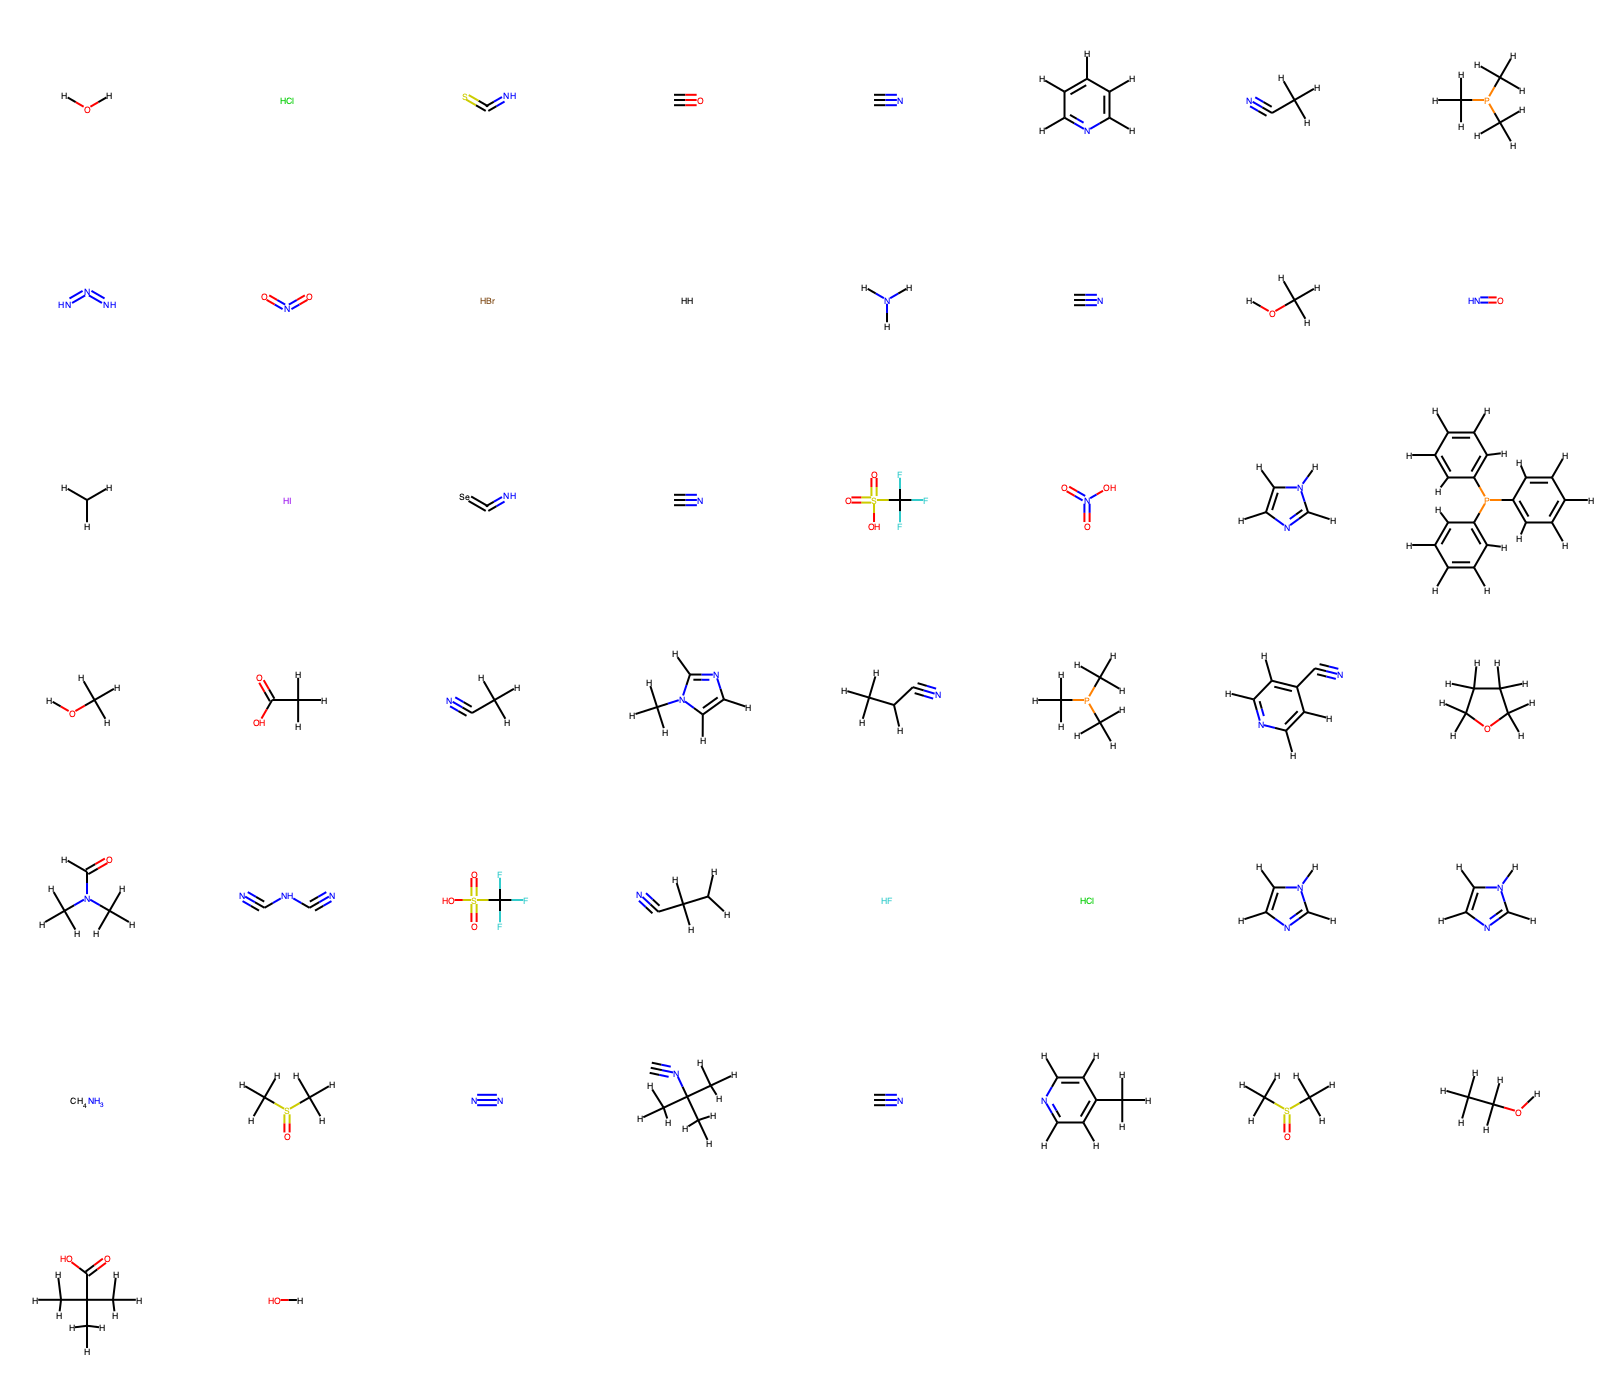

In [41]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if mod

def fingerprint_to_rdmol(fingerprint):
    rdmol = Chem.RWMol()
    indices = []
    numAtoms = len(fingerprint[0])
    for i in mydata[0]:
        indices = indices + [rdmol.AddAtom(Chem.Atom(str(i)))]
    assert indices[0] == 0
    for j in range(numAtoms):
        for k in range(j, numAtoms):
            bondOrder = fingerprint[3][j][k]
            if bondOrder == 7 or bondOrder == 9:
                #print "delocalized or Pi bond... unhandled"
                raise ValueError("delocalized or Pi bond... unhandled")
            bondTypes = Chem.rdchem.BondType
            bondOrders = {1:bondTypes.SINGLE, 2:bondTypes.DOUBLE, 3:bondTypes.TRIPLE,
                          4:bondTypes.QUADRUPLE, 5:bondTypes.AROMATIC, 7:bondTypes.AROMATIC, 9:bondTypes.AROMATIC}
            if bondOrder in bondOrders:
                rdmol.AddBond(indices[j], indices[k], bondOrders[bondOrder])
    return rdmol

mols = []
for i in range(90):
    try:
        mydata = reverseIntDict[str(topHits[i][0])]
        mols += [fingerprint_to_rdmol(mydata)]
    except:
        pass
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), highlightAtomLists=[0]*50, useSVG=False)